In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Stepwise loss approximation and threshold optimization through Gradient Descent

Conceptually, the problem of defining thresholds for protein families reduces to a trade off between data conservation and match elimination. In fact, one could decide to remove all matches, for instance by setting all thresholds to $0$, but it would inevitably lead to the loss of all data points or, on the other hand, one could decide to keep all data (all thresholds set to $1$) but this would mean all matches are still there.  
The hope is that it is possible to find a set of thresholds somewhere in the middle that allows to keep a good amount of data while removing almost all matches. Even with this reduced ($79$ families) dataset, the problem lies in a relatively high dimensional space, meaning that it is not feasible to define a grid and try many threshold sets in order to find the optimal one. One possibility is to define loss functions and use gradient-based optimization. A possible loss function is:

$$
\mathcal{L}=\mathcal{L_{data}}+\mathcal{L_{matches}}
$$

where $\mathcal{L_{data}}$ represents a loss that keeps into account how many datapoints are lost and $\mathcal{L_{matches}}$ represents a loss that keeps track of matches remaining in the dataset. A possible definition for these two losses is:
$$
\mathcal{L_{data}}(t)=\sum_{f \in families}\frac{|evalues[f]>t[f]|}{|f|}
$$
$$
\mathcal{L_{matches}}(t)=\frac{|surviving\space matches(t)|}{|matches|}
$$

The problem is that both definitions produce stepwise functions, which are not suitable for gradient descent.  
In this notebook neural networks are used to try and approximate these functions, making them suitable differentiable functions.


In [ ]:
#Same stuff from match checking notebook

target_names=[]
query_names=[]
e_values=[]
start=[]
end=[]
filename="hits_same_clan.scanned"
with open(filename) as file:
    for i, line in enumerate(file):
        if i<3:
            continue
        line=line.split()
        target_names.append(line[0])
        query_names.append(line[3])
        e_values.append(line[6])
        start.append(line[17])
        end.append(line[18])

In [ ]:
target_names=np.array(target_names)
query_names=np.array(query_names)
e_values=np.array(e_values)
start=np.array(start)
end=np.array(end)

In [ ]:
families=np.unique(query_names)
family_index={family: np.where(families==family)[0][0] for family in families}
family_sizes=np.zeros_like(families, dtype=np.int32)
data={
    "protein": target_names,
    "family": query_names,
    "evalue": e_values,
    "start": start,
    "end":end
}
df=pd.DataFrame(data)
def intersection_size(start1, start2, end1, end2):
    return len(range(max(start1, start2), min(end1, end2)))
def union_size(start1, start2, end1, end2):
    return len(range(start1, end1))+len(range(start2, end2))-intersection_size(start1, start2, end1, end2)
def match(row1, row2):
    start1=int(row1[3])
    start2=int(row2[3])
    end1=int(row1[4])
    end2=int(row2[4])
    if intersection_size(start1, start2, end1, end2)/union_size(start1, start2, end1, end2)>0.8:
        return True
    return False

In [ ]:
matches=np.zeros((len(families), len(families)))
ev_tensor=np.ones((len(families), len(families), 2))

In [ ]:
df=df.sort_values("protein", ignore_index=True)

Same as match checking, but now each match is stored in a list in the form $[family1, evalue1, family2, evalue2]$.

In [ ]:
i=0
n=len(df)
data=df.to_numpy()
match_list=[]
for i in range(n-1):
    print(str(i)+'/'+str(n), end='\r')
    ith_row=data[i]
    protein=ith_row[0]
    family1=ith_row[1]
    evalue1=float(ith_row[2])
    family_sizes[family_index[family1]]+=1
    j=i+1
    jth_row=data[j]
    while jth_row[0]==protein:
        family2=jth_row[1]
        evalue2=float(jth_row[2])
        if family2!=family1 and match(ith_row, jth_row):
            fam1index=family_index[family1]
            fam2index=family_index[family2]
            matches[fam1index, fam2index]+=1
            match_list.append(np.array([fam1index, evalue1, fam2index, evalue2]))
        j+=1
        if j==n:
            break
        jth_row=data[j]

Here I am saving in a tensor the list of evalues for each family.

In [ ]:
family_evalues=np.zeros((len(families), np.max(family_sizes)))
for fam in families:
    temp=np.array(df.loc[df['family'] == fam]['evalue'])
    family_evalues[family_index[fam], :temp.shape[0]]=temp
family_evalues=torch.tensor(family_evalues, requires_grad=True)
family_sizes=torch.tensor(family_sizes, dtype=torch.float, requires_grad=True)
match_list=torch.tensor(match_list)

In [ ]:
normalized_matrix=np.zeros_like(matches)
for i in range(len(families)):
    for j in range(i,len(families)):
        matches[i, j]+=matches[j, i]
        normalized_matrix[i, j]/=min(family_sizes[i], family_sizes[j])
        matches[j, i]=matches[i, j]
        normalized_matrix[j,i]=normalized_matrix[i,j]

### 1. Approximating the family-specific lost datapoints loss function (part of $\mathcal{L_{data}}$)

Written below is the real (non differentiable) loss function we want to approximate. Given a threshold and a family, this function returns the ratio of datapoints of that family that would be lost by setting that specific threshold.

In [ ]:
def lost_data(threshold, family):
    lost_datapoints=torch.stack([torch.sum(torch.gt(family_evalues[family,:], t)) for t in threshold])
    return torch.div(lost_datapoints, family_sizes[family]).reshape(-1, 1)

And this is the neural net that can be used to approximate this loss for each family: it takes one input (the treshold) and returns one output (the ratio of lost data, squeezed between $0$ and $1$ through a sigmoid function). The input is transformed through a $\log$ function for numeric reasons (it improves convergence).

In [ ]:
class loss_approximator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        input=torch.log(x)
        return torch.sigmoid(self.layers(input))

Training is performed separately for different families: an input $x \in [0,1]$ is sampled by first sampling uniformly between $0$ and $1$ and then raising this number to a random power between $-10$ and $0$. This is done because it is extremely important to approximate the function properly for very small inputs, that naive uniform sampling would almost never produce.  
Then this input is fed into the neural networks for all classes and the results are compared to the target values by means of mean squared error loss.  
A kind of early stopping technique is adopted: initially all families are processed, but as soon as training can be considered completed for a certain family, it is interrupted to speed up the whole process. Training is considered completed if the loss is below a certain threshold and if the value of the approximated function in $1$ is reasonably close to $0$.

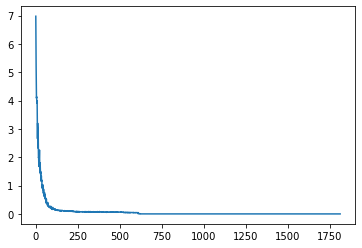

In [ ]:
torch.manual_seed(0)
batch_size=128
family_loss_approximator=[loss_approximator() for i in range(len(families))]
optimizer_list = [torch.optim.AdamW(net.parameters(), lr=0.01) for net in family_loss_approximator]
loss=torch.nn.MSELoss()
losses=[]
toprocess=np.arange(len(families))
loss_threshold=0.0001
threshold_at_one=0.05
epoch=0
while len(toprocess)>0:
    epoch+=1
    randomint=torch.randint(high=10, size=(batch_size,)).float()
    x=(torch.rand(batch_size)*(10**-randomint)).reshape(batch_size, 1)
    total_loss=0
    for i in toprocess:
        l_hat=family_loss_approximator[i](x)
        l_true=lost_data(x, i)
        l=loss(l_hat, l_true)
        total_loss+=l.item()
        optimizer_list[i].zero_grad()
        l.backward()
        if l<loss_threshold and family_loss_approximator[i](torch.ones(1,1))<threshold_at_one:
            toprocess=np.delete(toprocess, np.where(toprocess==i))
        optimizer_list[i].step()
    losses.append(total_loss)
    print("epoch: "+str(epoch)+", loss: "+"{:.6f}".format(total_loss)+", families to process: "+str(len(toprocess)), end='\r')
plt.plot(losses)

We can see from these plots that approximation is very good for most of the families even with a relatively quick learning (9 minutes on a laptop CPU).

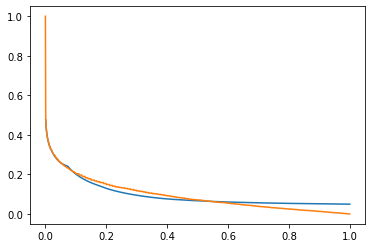

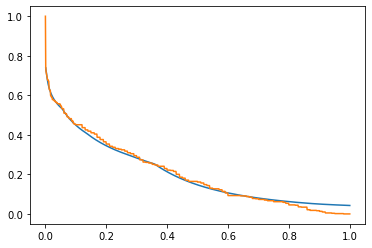

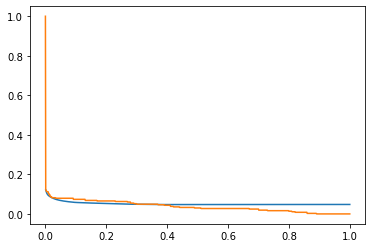

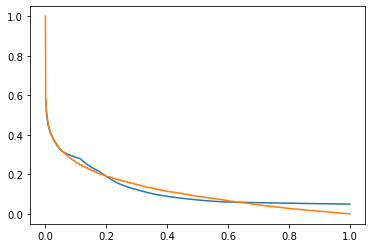

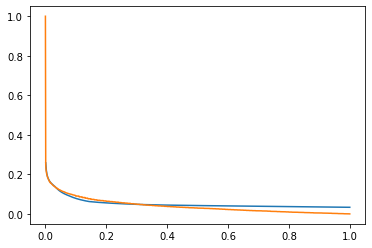

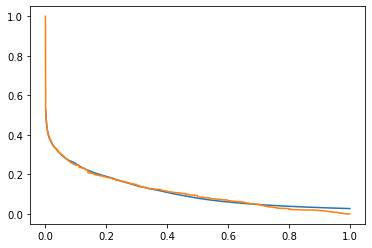

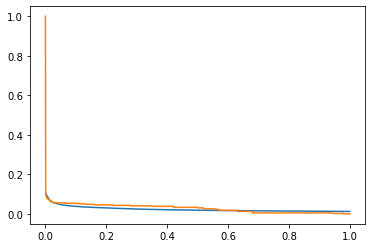

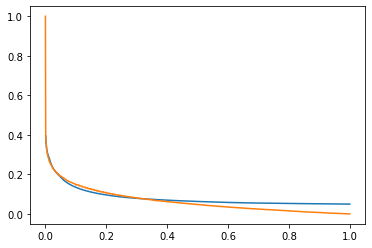

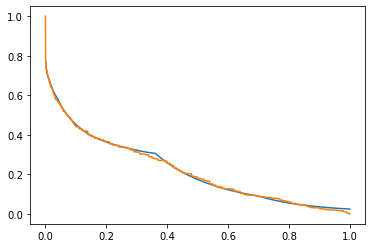

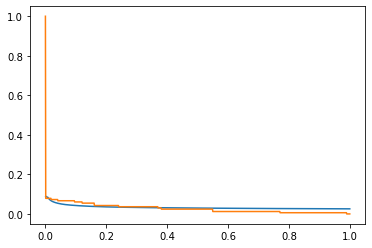

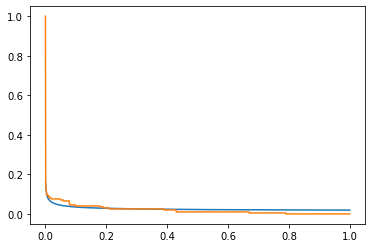

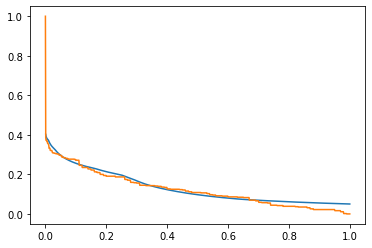

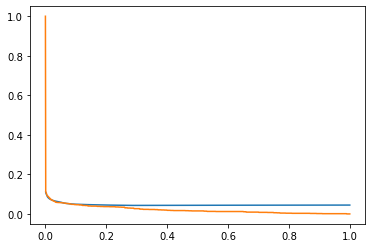

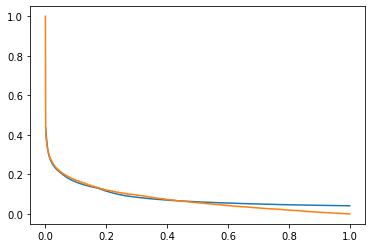

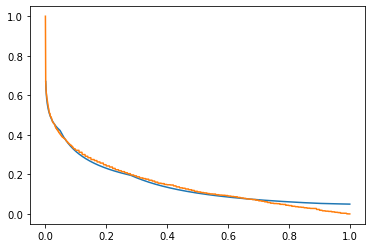

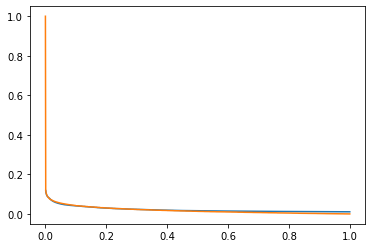

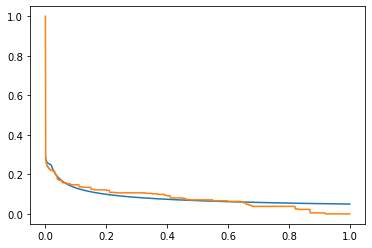

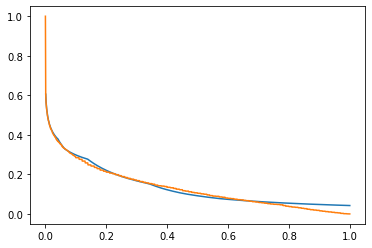

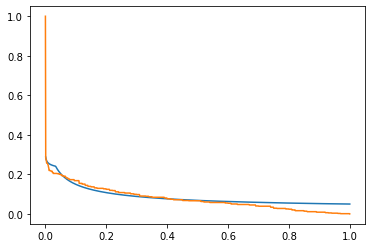

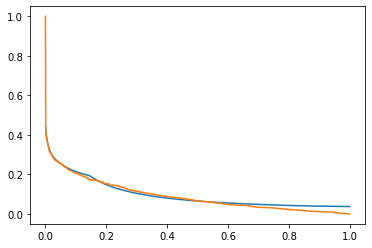

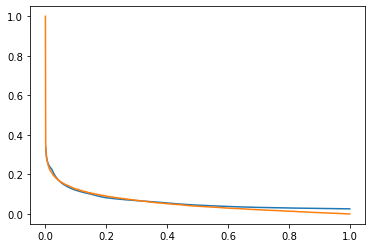

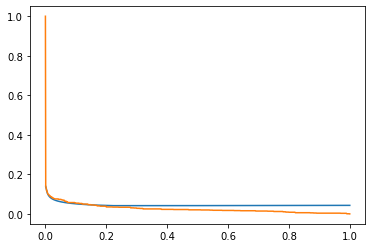

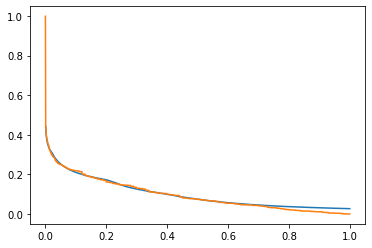

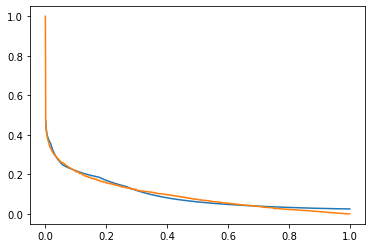

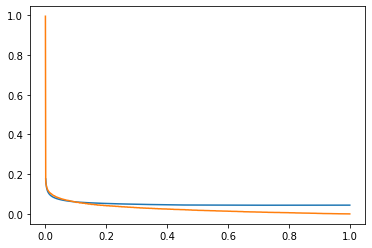

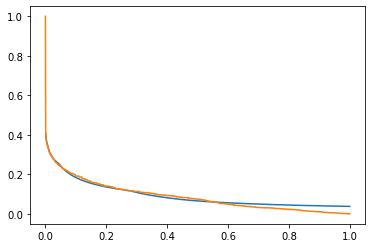

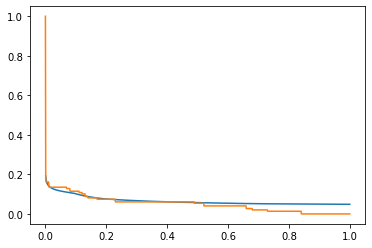

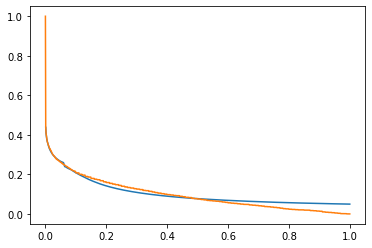

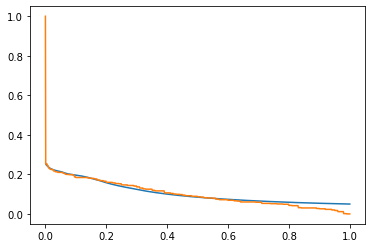

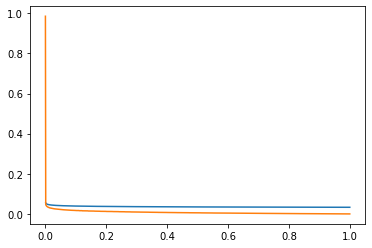

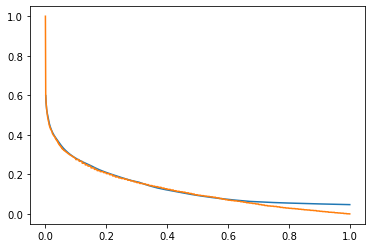

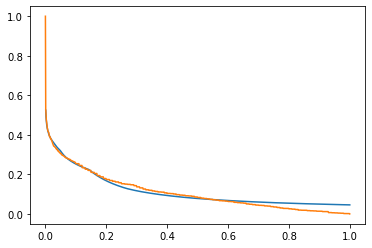

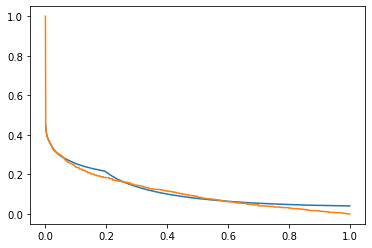

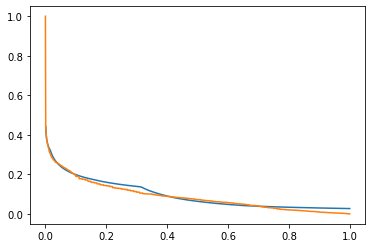

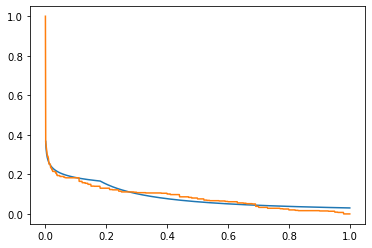

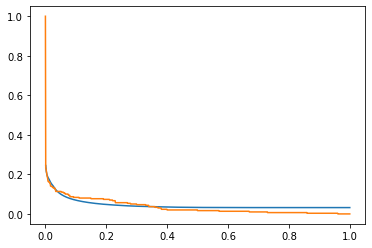

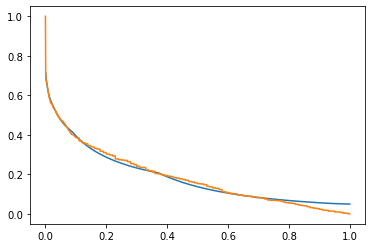

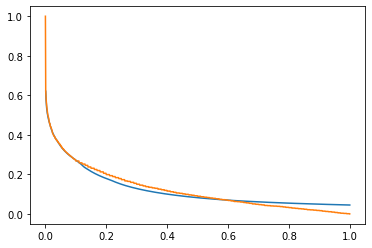

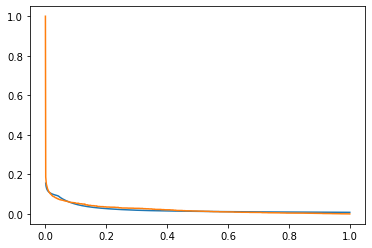

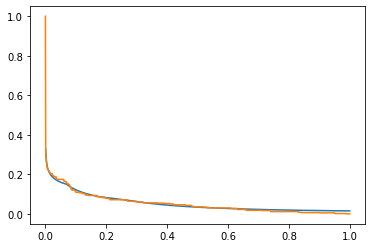

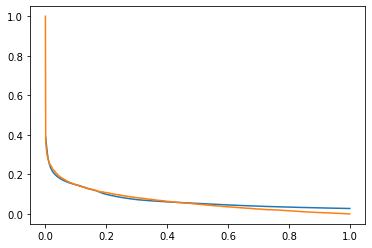

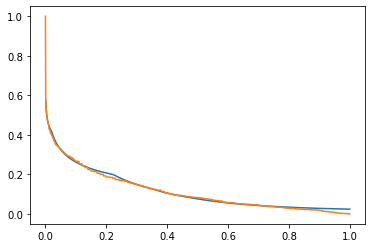

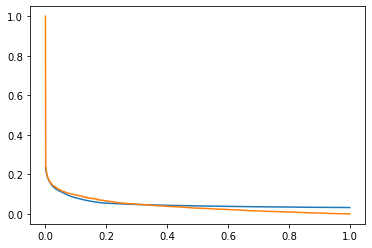

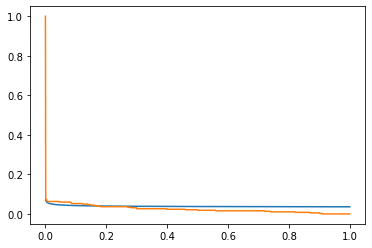

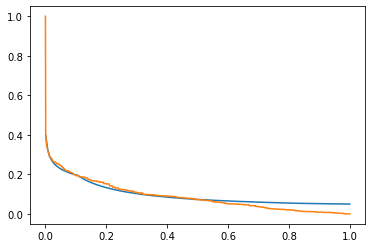

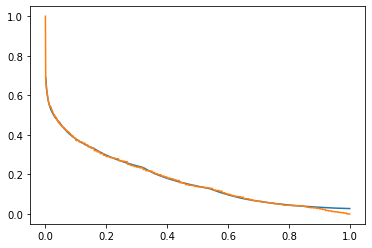

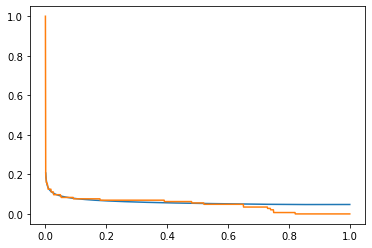

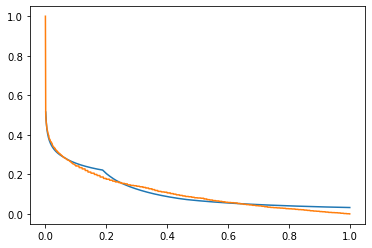

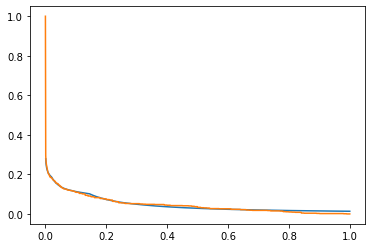

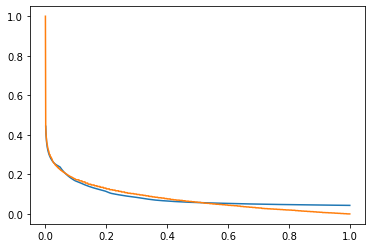

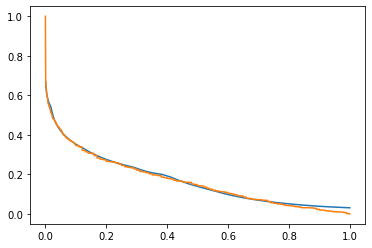

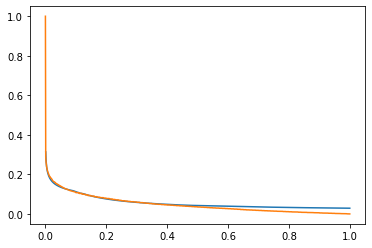

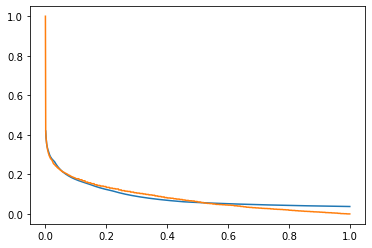

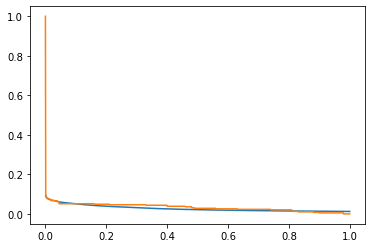

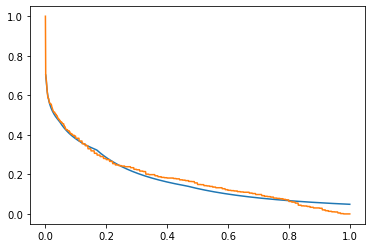

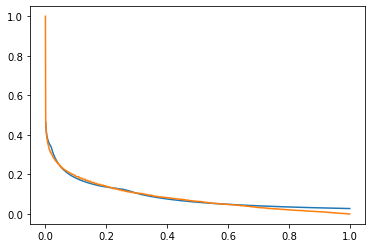

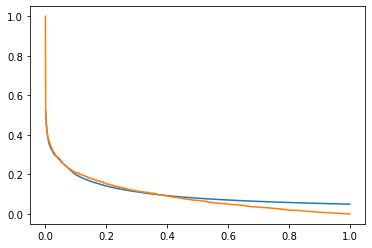

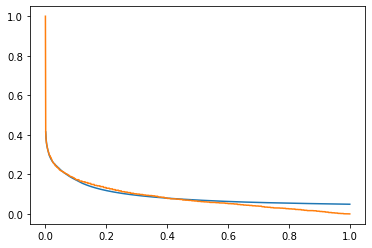

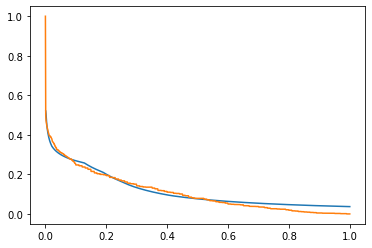

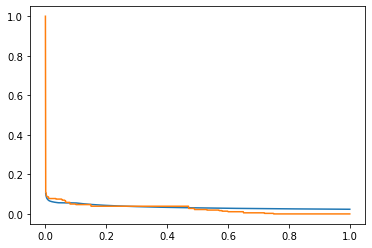

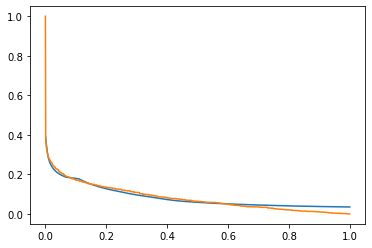

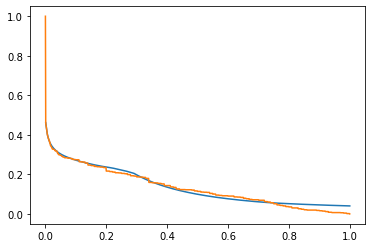

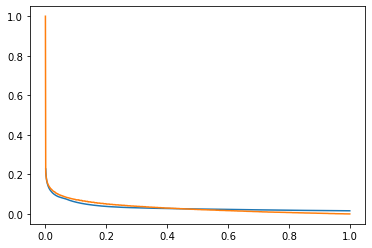

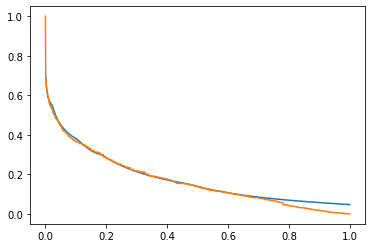

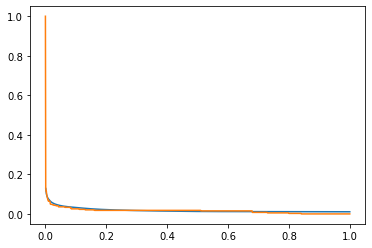

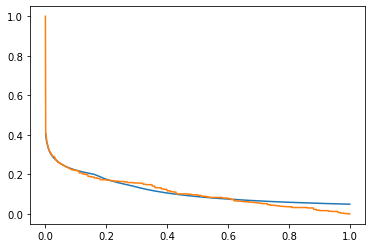

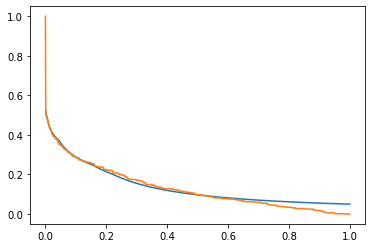

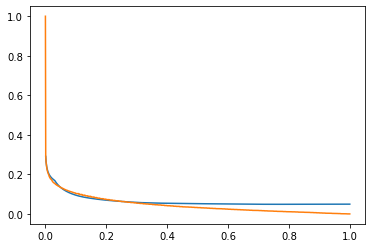

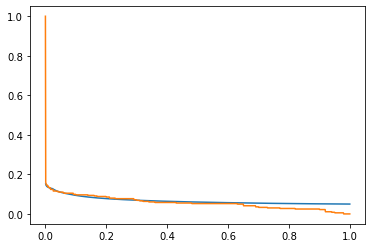

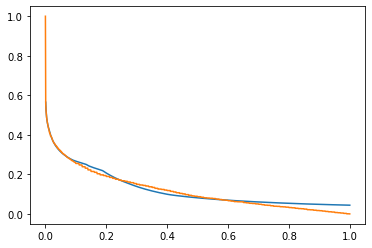

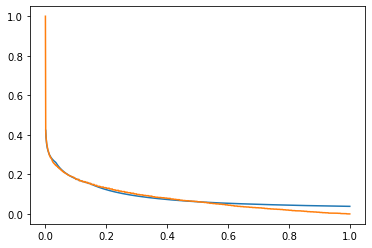

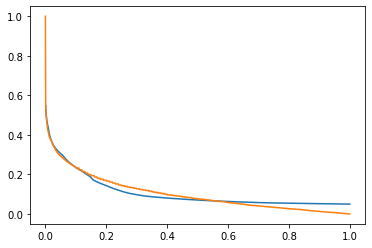

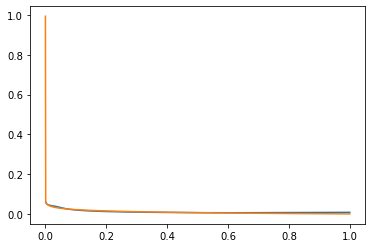

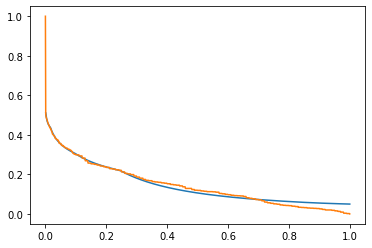

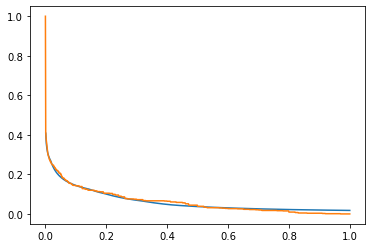

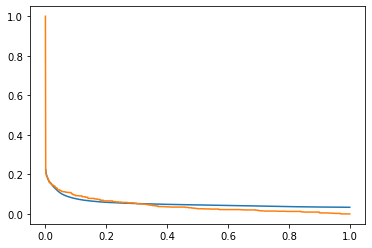

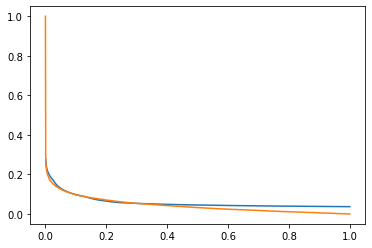

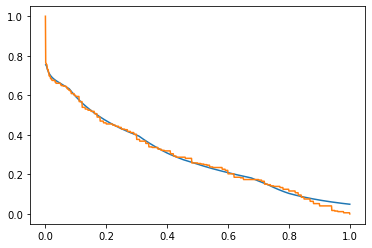

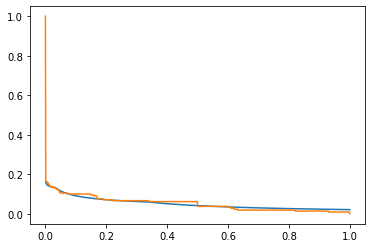

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_until=1
for j in range(79):
    list1=[]
    list2=[]
    for i in np.linspace(0,plot_until,1001):
        list1.append(family_loss_approximator[j](torch.ones(1)*i).item())
        list2.append(lost_data(torch.ones(1)*i, j).item())
    plt.plot(np.linspace(0,plot_until,1001), list1)
    plt.plot(np.linspace(0,plot_until,1001), list2)
    plt.show()
    plt.figure()


### 2. Approximating the match-related loss function ($\mathcal{L_{matches}}$)

Approximating $\mathcal{L_{matches}}$ is apparently much more challenging, since in principle this is a function of all the thresholds ($|f|$). However, using another approximation, in the whole notebook matches are defined pairwise (meaning that if a certain part of a certain protein belongs to families A, B and C, this does not count as one match but as three matches AB, BC, AC).  
This means that it is possible to decompose the number of remaining matches into sums of remaining matches between couples of families:
$$
\mathcal{L_{matches}(t)}=\frac{|surviving\space matches(t)|}{|matches|}=\sum_{f, g \in families}\frac{|surviving\space matches(t_f, t_g)|}{|matches|}
$$
With this decomposition, an approach very similar to the one used for the other part of the loss is suitable: a neural network is trained for each couple of matching families $f,g$ to approximate $|surviving\space matches(t_f, t_g)|$.  
Here, things could get very difficult on the entire dataset, which one would expect to contain many more families and matches. However,
- this relatively small dataset should be way "denser" in matches than the real one, since it was hand-picked to contain matches;
- one can decide to consider only pairs of families with more than a certain number of matches, to reduce computational cost

This is the "real" loss we want to approximate, expressed here as a function of the vector $t$ (not as a sum over pairs):

In [ ]:
def surviving_matches(thresholds):
    A=torch.index_select(thresholds, 1, match_list[:,0].int())
    B=match_list[:,1]
    C=torch.index_select(thresholds, 1, match_list[:,2].int())
    D=match_list[:,3]
    return torch.sum(torch.logical_and(torch.gt(A ,B), torch.gt(C ,D)), dim=1)
def relative_surviving_matches(thresholds):
    return torch.div(surviving_matches(thresholds), len(match_list)).reshape(-1,1)

As anticipated, a threshold (of another kind) can be set to ignore not particularly relevant couples:

In [ ]:
minimum_matches=10
relevant_matches=torch.tensor(np.where(matches>minimum_matches))
weights=torch.tensor(matches[np.where(matches>minimum_matches)])
indices=torch.gt(relevant_matches[1], relevant_matches[0])
relevant_matches=relevant_matches[:,indices]
weights=weights[indices]

This function computes a list of e-values for matches between families of a certain `pair`.

In [ ]:
def evalues_per_pair(pair):
    set1=torch.logical_and(torch.eq(match_list[:,0], relevant_matches[:,pair][1]), torch.eq(match_list[:,2], relevant_matches[:,pair][0]))
    set2=torch.logical_and(torch.eq(match_list[:,0], relevant_matches[:,pair][0]), torch.eq(match_list[:,2], relevant_matches[:,pair][1]))
    ev1_set1=match_list[set1,1]
    ev0_set1=match_list[set1,3]
    ev0_set2=match_list[set2,1]
    ev1_set2=match_list[set2,3]
    ev1=torch.cat([ev1_set1, ev1_set2])
    ev0=torch.cat([ev0_set1, ev0_set2])
    return torch.stack([ev0, ev1], dim=1)

In [ ]:
pair_evalues=[]
for i in range(len(weights)):
    pair_evalues.append(evalues_per_pair(i))

This function is the one that will be directly approximated by our neural network: the single entry of the sum on pairs of families.

In [ ]:
def pair_surviving_matches(pair, thresholds):
    ev_tensor=pair_evalues[pair]
    p1=torch.lt(ev_tensor[:,0], thresholds[:,0].reshape(-1,1))
    p2=torch.lt(ev_tensor[:,1], thresholds[:,1].reshape(-1,1))
    return torch.div(torch.sum(torch.logical_and(p1,p2), dim=1), weights[pair]).float()

The architecture is basically identical to the first set of NNs and once again, $\log$ transformation of inputs turns out to be very useful for convergence.

In [ ]:
class pair_approximator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8,4),
            nn.LeakyReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        input=torch.log10(x)
        return torch.sigmoid(self.layers(input))

Training is performed exactly as in the previous case (just for pairs of families and not single families). Training takes approximately 4 minutes on a laptop CPU.

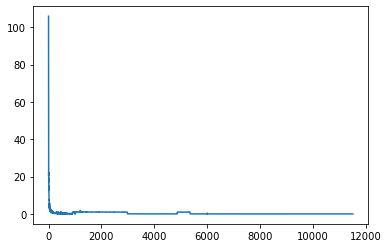

In [ ]:
torch.manual_seed(0)
batch_size=128
threshold_on_vertex=0.9
loss_threshold=0.001
pair_matches_approximator=[pair_approximator() for i in range(len(weights))]
optimizer_list = [torch.optim.AdamW(net.parameters(), lr=0.1) for net in pair_matches_approximator]
loss=torch.nn.MSELoss()
losses=[]
toprocess=np.arange(len(weights))
epoch=0
while len(toprocess)>0:
    epoch+=1
    randomint=torch.randint(high=10, size=(batch_size, 2)).float()
    x=(torch.rand(batch_size, 2)*(10**-randomint)).reshape(batch_size, 2)
    total_loss=0
    for i in toprocess:
        l_hat=pair_matches_approximator[i](x)
        l_true=pair_surviving_matches(i, x).reshape(-1,1)
        l=loss(l_hat, l_true)
        if l<loss_threshold and pair_matches_approximator[i](torch.ones(1,2))>threshold_on_vertex:
            toprocess=np.delete(toprocess, np.where(toprocess==i))
        total_loss+=l.item()
        optimizer_list[i].zero_grad()
        l.backward()
        optimizer_list[i].step()
    losses.append(total_loss)
    print("epoch: "+str(epoch)+", loss: "+"{:.6f}".format(total_loss)+", pairs to process: "+str(len(toprocess)), end='\r')
plt.plot(losses)

### 3. Optimizing matches through surrogate losses
Once the two pieces of $\mathcal{L}$ are available, we can start looking for the optimal set of thresholds. This can be simply done with gradient-based methods using a "fake" neural network with just one layer which takes always $1$ as an input and has no biases: the weights will be our thresholds.

In [ ]:
class lift(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, dim, bias=False)
        )
        
    def forward(self):
        return torch.sigmoid(self.layers(torch.ones(1)))


Epoch:  0
Remaining matches:  0.7446826100349426 0.757088303565979
Lost data:  0.0084943613037467 0.006524789612740278
Approximated loss:  0.7531769871711731
Real loss:  0.7636131048202515

Epoch:  100
Remaining matches:  0.4408976435661316 0.44083213806152344
Lost data:  0.05387234687805176 0.05268559977412224
Approximated loss:  0.49476999044418335
Real loss:  0.4935177266597748

Epoch:  200
Remaining matches:  0.3261645436286926 0.3250272870063782
Lost data:  0.07098200917243958 0.07120122760534286
Approximated loss:  0.3971465528011322
Real loss:  0.39622852206230164

Epoch:  300
Remaining matches:  0.26605191826820374 0.2686448097229004
Lost data:  0.08030394464731216 0.08064693957567215
Approximated loss:  0.3463558554649353
Real loss:  0.34929174184799194

Epoch:  400
Remaining matches:  0.23859702050685883 0.24205784499645233
Lost data:  0.08463261276483536 0.08440496772527695
Approximated loss:  0.3232296407222748
Real loss:  0.3264628052711487

Epoch:  500
Remaining matches:

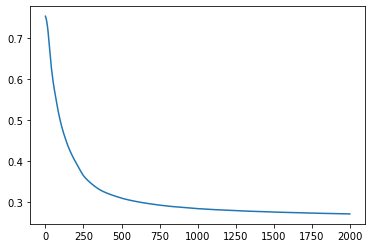

In [ ]:
torch.manual_seed(0)
d=lift(len(families))
for net in family_loss_approximator:
    net.eval()
for net in pair_matches_approximator:
    net.eval()
optimizer=torch.optim.AdamW(d.parameters(), lr=0.1)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
losses=[]
alpha=0.8
beta=1-alpha
for epoch in range(2000):
    t=d().reshape(1,-1)
    l=alpha*sum([pair_matches_approximator[i](t[:,relevant_matches[:,i]])*weights[i] for i in range(len(weights))])/len(match_list)+beta*sum([family_loss_approximator[i](t[:,i])*family_sizes[i] for i in range(len(families))])/len(df)
    if epoch%100==0:
        print("\nEpoch: ", epoch)
        print("Remaining matches: ", (alpha*sum([pair_matches_approximator[i](t[:,relevant_matches[:,i]])*weights[i] for i in range(len(weights))])/len(match_list)).item(), (alpha*relative_surviving_matches(t)).item())
        print("Lost data: ", (beta*sum([family_loss_approximator[i](t[:,i])*family_sizes[i] for i in range(len(families))])/len(df)).item(), (beta*sum([lost_data(t[:,i], i)*family_sizes[i] for i in range(len(families))])/len(df)).item())
        print("Approximated loss: ", l.item())
        print("Real loss: ", (alpha*relative_surviving_matches(t)+beta*sum([lost_data(t[:,i], i)*family_sizes[i] for i in range(79)])/len(df)).item())
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()
    losses.append(l)
plt.plot(losses)

### 4. Results

In [ ]:
d()

tensor([4.1060e-01, 2.4383e-03, 3.8430e-01, 2.3738e-12, 1.8511e-08, 9.9751e-01,
        9.9681e-01, 3.6261e-16, 1.1385e-06, 9.9382e-01, 9.9379e-01, 1.1518e-07,
        2.7829e-01, 2.4362e-12, 5.3713e-11, 7.0018e-08, 9.9707e-01, 9.2669e-12,
        9.7769e-01, 1.7950e-10, 3.8200e-15, 3.5811e-01, 9.2790e-01, 2.1286e-09,
        2.2445e-08, 8.0629e-12, 9.9526e-01, 6.4355e-10, 4.4902e-10, 5.6964e-03,
        1.7683e-09, 8.0006e-11, 2.1623e-08, 6.4002e-12, 9.4260e-01, 8.7088e-01,
        2.4283e-03, 2.0983e-11, 9.9818e-01, 9.9760e-01, 2.7905e-15, 7.8518e-09,
        2.3831e-16, 9.9230e-01, 2.9177e-13, 1.8188e-07, 8.8545e-01, 1.7782e-12,
        9.9343e-01, 8.0499e-03, 1.7152e-06, 6.9226e-19, 6.7580e-15, 4.9674e-09,
        3.8508e-07, 1.7880e-12, 7.8714e-01, 8.0533e-08, 9.8815e-01, 9.9611e-01,
        8.5770e-01, 4.1628e-07, 2.6143e-10, 2.7406e-09, 5.2025e-01, 9.9455e-01,
        1.4139e-07, 1.8167e-12, 9.9719e-01, 2.9831e-10, 3.9032e-11, 1.0154e-11,
        6.8209e-02, 9.9830e-01, 2.1147e-

In [ ]:
print("Surviving matches: ", relative_surviving_matches(d().reshape(1,-1)).item())
print("Lost data: ", (sum([lost_data(d()[i].reshape(1), i)*family_sizes[i] for i in range(len(families))])/len(df)).item())

Surviving matches:  0.22101350128650665
Lost data:  0.4678483009338379
